# Centroid-based clustering algorithms

Explore performance of centroid-based clustering algorithms. 

refs: https://jakevdp.github.io/PythonDataScienceHandbook/05.12-gaussian-mixtures.html

In [35]:
import numpy as np
import awkward as ak

from sklearn.cluster import KMeans
from sklearn.mixture import GaussianMixture

from reco.event import get_bary_data, get_lc_data, get_event_data, clusters_by_indices, remap_arrays_by_label, remap_items_by_label
from reco.plotting import plot_sim_reco, plot_tracksters
from reco.energy import get_total_energy



from reco.evaluation import evaluate, evaluate_remapped, run_evaluation

# plotting config
import matplotlib.pyplot as plt
from matplotlib import rc
rc('font',**{'family':'sans-serif','sans-serif':['DejaVu Sans'],'size': 12})
rc('mathtext',**{'default':'regular'})
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

ds_name = "CloseByTwoPion"
file_name = "new_ntuples_15101852_0.root"

data_root = "data"
raw_dir = f"/Users/ecuba/data/{ds_name}"
file_path = f"{raw_dir}/{file_name}"

In [36]:
cluster_data, trackster_data, simtrackster_data, assoc_data = get_event_data(file_path)

### Extract the event data and evaluate

In [47]:
eid = 1

t_indexes = trackster_data["vertices_indexes"][eid]
t_multiplicity = trackster_data["vertices_multiplicity"][eid]

# simulation
st_indexes = simtrackster_data["stsSC_vertices_indexes"][eid]
st_multiplicity = simtrackster_data["stsSC_vertices_multiplicity"][eid]

t_x, t_y, t_z, t_energy = clusters_by_indices(cluster_data, t_indexes, eid)
st_x, st_y, st_z, st_energy = clusters_by_indices(cluster_data, st_indexes, eid)

nhits = cluster_data["cluster_number_of_hits"][eid]

Tracksters reco: 15, tracksters sim: 2
Simulated energy: 238.73 GeV, reconstructed energy: 146.32 GeV (61.29%)


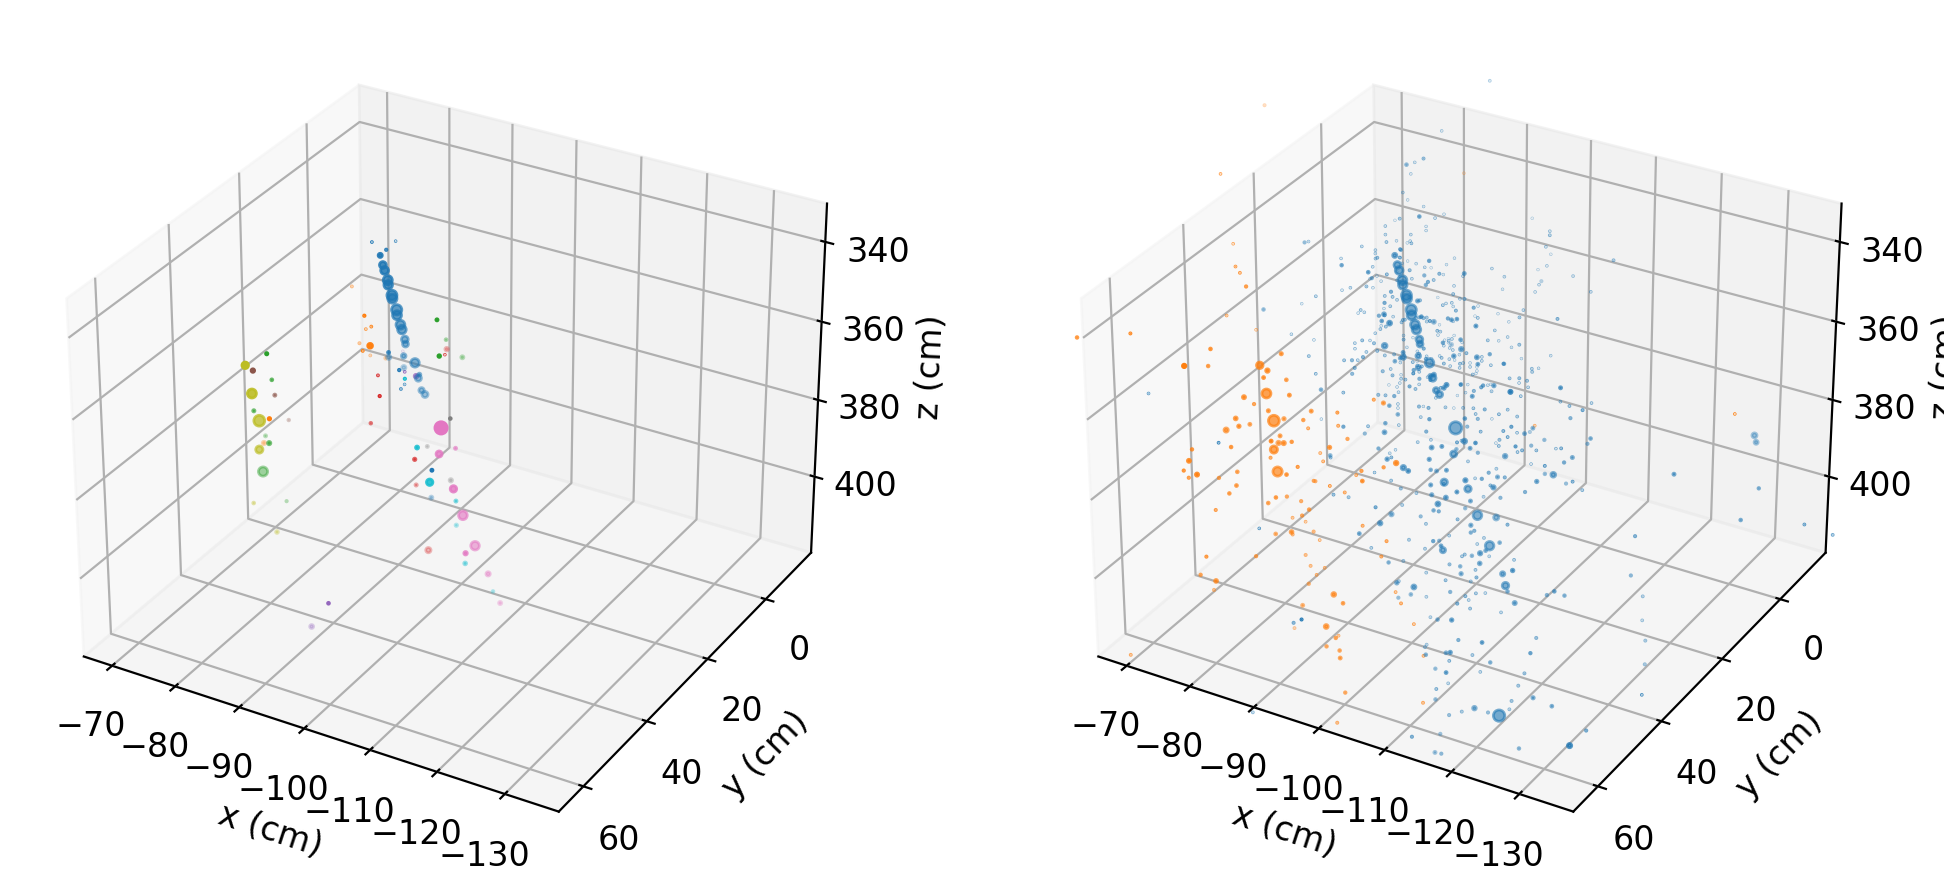

In [48]:
print(f"Tracksters reco: {len(t_indexes)}, tracksters sim: {len(st_indexes)}")

reco_total = get_total_energy(t_energy, t_multiplicity)
sim_total = get_total_energy(st_energy, st_multiplicity)
print(f"Simulated energy: {sim_total:.2f} GeV, reconstructed energy: {reco_total:.2f} GeV ({(reco_total / sim_total) * 100:.2f}%)")

ax1, ax2 = plot_sim_reco(
    t_x,
    t_y,
    t_z,
    t_energy,
    st_x,
    st_y,
    st_z,
    st_energy, 
    st_indexes,
    st_multiplicity,
)

In [49]:
precision, recall, fscore = evaluate(
    nhits,
    t_indexes,
    st_indexes,
    t_energy,
    st_energy,
    t_multiplicity,
    st_multiplicity
)
print(f"Precision: {precision:.2f}, Recall: {recall:.2f}, F-score: {fscore:.2f}")

Precision: 1.00, Recall: 0.14, F-score: 0.17


## k-means

Apply k-means algorithm on CLUE3D barycentres

Centres: 3


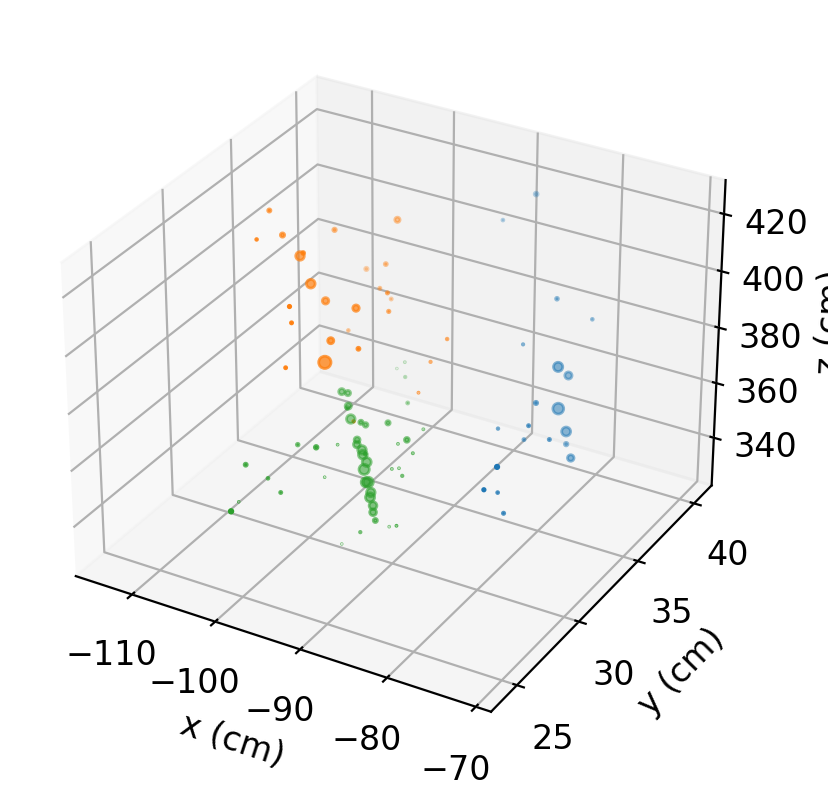

In [50]:
# kmeans on barycentres

K = sum(trackster_data["raw_energy"][eid] > 10)

print("Centres:", K)

def kmeans_bary(_data, _eid, K=10):
    X_bary = get_bary_data(_data, _eid)
    raw_e = _data["raw_energy"][_eid]
    kmeans = KMeans(n_clusters=K, random_state=0).fit(X_bary, sample_weight=raw_e)
    return kmeans.labels_

labels = kmeans_bary(trackster_data, eid, K=K)

r_indexes = remap_arrays_by_label(t_indexes, labels)
r_x, r_y, r_z, r_e = clusters_by_indices(cluster_data, r_indexes, eid)

fig = plt.figure()
ax = fig.add_subplot(111, projection="3d")
plot_tracksters(ax, r_x, r_y, r_z, r_e)

In [51]:
precision, recall, fscore = evaluate_remapped(nhits, t_indexes, st_indexes, t_energy, st_energy, t_multiplicity, st_multiplicity, labels)
print(f"Precision: {precision:.2f}, Recall: {recall:.2f}, F-score: {fscore:.2f}")

Precision: 1.00, Recall: 0.31, F-score: 0.36


In [52]:
### Running it on layerclusters - for comparison

Precision: 1.00, Recall: 0.32, F-score: 0.37


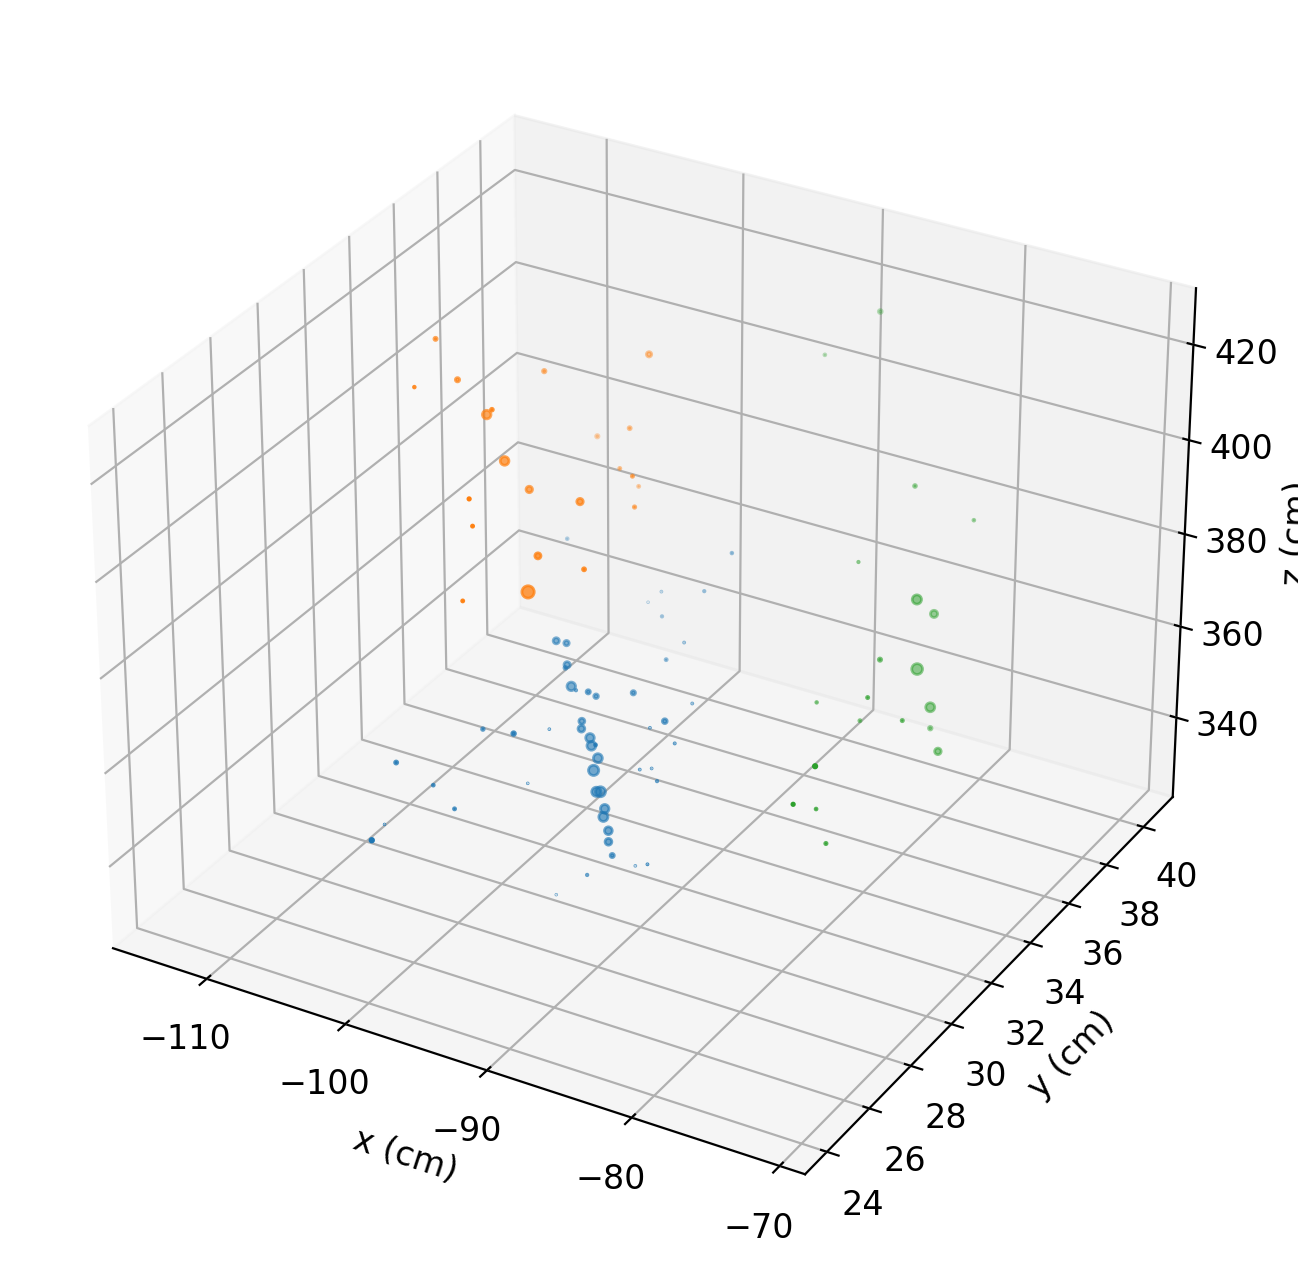

In [53]:
# kmeans on layerclusters (for comparison)
K = sum(trackster_data["raw_energy"][eid] > 10)

X_vertices = get_lc_data(cluster_data, trackster_data, eid)
kmeans = KMeans(n_clusters=K, random_state=0).fit(X_vertices)

ri = remap_items_by_label(ak.flatten(t_indexes), kmeans.labels_)
re = remap_items_by_label(ak.flatten(t_energy), kmeans.labels_)
rm = remap_items_by_label(ak.flatten(t_multiplicity), kmeans.labels_)

precision, recall, fscore = evaluate(nhits, ri, st_indexes, re, st_energy, rm, st_multiplicity)
print(f"Precision: {precision:.2f}, Recall: {recall:.2f}, F-score: {fscore:.2f}")


rx = remap_items_by_label(ak.flatten(t_x), kmeans.labels_)
ry = remap_items_by_label(ak.flatten(t_y), kmeans.labels_)
rz = remap_items_by_label(ak.flatten(t_z), kmeans.labels_)
re = remap_items_by_label(ak.flatten(t_energy), kmeans.labels_)
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')
plot_tracksters(ax, rx, ry, rz, re)
plt.show()

## GMM

Apply Gaussian Mixture Models on barycentres and layerclusters

Centres: 3


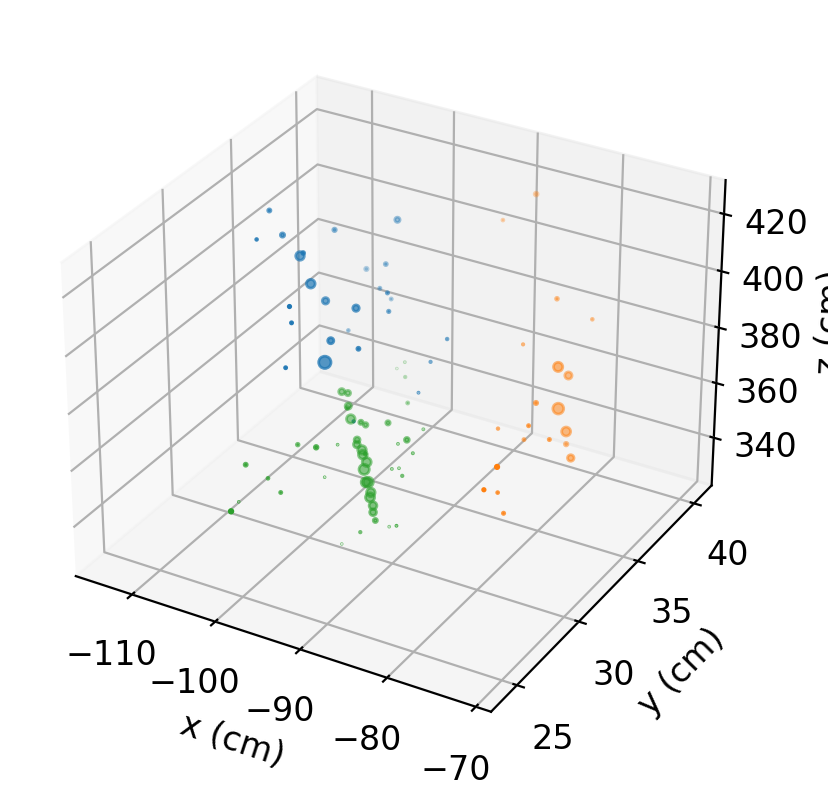

In [54]:
# kmeans on barycentres

K = sum(trackster_data["raw_energy"][eid] > 10)
print("Centres:", K)

def gmm_bary(_data, _eid, K=10):
    X_bary = get_bary_data(_data, _eid)
    gmm = GaussianMixture(n_components=K, covariance_type='full').fit(X_bary)
    return gmm.predict(X_bary)

gmm_labels = gmm_bary(trackster_data, eid, K=K)
r_indexes = remap_arrays_by_label(t_indexes, gmm_labels)
r_x, r_y, r_z, r_e = clusters_by_indices(cluster_data, r_indexes, eid)

fig = plt.figure()
ax = fig.add_subplot(111, projection="3d")
plot_tracksters(ax, r_x, r_y, r_z, r_e)

In [55]:
precision, recall, fscore = evaluate_remapped(nhits, t_indexes, st_indexes, t_energy, st_energy, t_multiplicity, st_multiplicity, gmm_labels)
print(f"Precision: {precision:.2f}, Recall: {recall:.2f}, F-score: {fscore:.2f}")

Precision: 1.00, Recall: 0.31, F-score: 0.36


## Evaluations

In [11]:
# TODO: rework this to support the data based stuff
run_evaluation(kmeans_bary, tracksters, simtracksters, associations, K=18)

E0: nTIn: 94	nTSim: 10	nTGt: 19	nTReco: 18	P: 0.77 R: 0.74 F:0.75
E1: nTIn: 123	nTSim: 10	nTGt: 37	nTReco: 18	P: 0.51 R: 0.80 F:0.62
E2: nTIn: 97	nTSim: 10	nTGt: 33	nTReco: 18	P: 0.64 R: 0.85 F:0.73
E3: nTIn: 104	nTSim: 10	nTGt: 39	nTReco: 18	P: 0.63 R: 0.79 F:0.70
E4: nTIn: 76	nTSim: 10	nTGt: 32	nTReco: 18	P: 0.55 R: 0.83 F:0.66
E5: nTIn: 35	nTSim: 10	nTGt: 15	nTReco: 18	P: 0.95 R: 0.66 F:0.78
E6: nTIn: 34	nTSim: 10	nTGt: 12	nTReco: 18	P: 0.82 R: 0.81 F:0.81
E7: nTIn: 36	nTSim: 10	nTGt: 17	nTReco: 18	P: 0.83 R: 0.84 F:0.83
E8: nTIn: 81	nTSim: 10	nTGt: 45	nTReco: 18	P: 0.44 R: 0.80 F:0.56
E9: nTIn: 44	nTSim: 10	nTGt: 20	nTReco: 18	P: 0.83 R: 0.91 F:0.87
E10: nTIn: 97	nTSim: 10	nTGt: 25	nTReco: 18	P: 0.80 R: 0.85 F:0.83
E11: nTIn: 64	nTSim: 10	nTGt: 20	nTReco: 18	P: 0.60 R: 0.77 F:0.68
E12: nTIn: 30	nTSim: 10	nTGt: 10	nTReco: 18	P: 0.89 R: 0.67 F:0.77
E13: nTIn: 108	nTSim: 10	nTGt: 40	nTReco: 18	P: 0.66 R: 0.83 F:0.73
E14: nTIn: 26	nTSim: 10	nTGt: 15	nTReco: 18	P: 0.99 R: 0.92 F:0.95
E1

In [12]:
run_evaluation(gmm_bary, tracksters, simtracksters, associations, K=18)

E0: nTIn: 94	nTSim: 10	nTGt: 19	nTReco: 18	P: 0.70 R: 0.70 F:0.70
E1: nTIn: 123	nTSim: 10	nTGt: 37	nTReco: 18	P: 0.46 R: 0.74 F:0.56
E2: nTIn: 97	nTSim: 10	nTGt: 33	nTReco: 18	P: 0.68 R: 0.84 F:0.75
E3: nTIn: 104	nTSim: 10	nTGt: 39	nTReco: 18	P: 0.66 R: 0.83 F:0.74
E4: nTIn: 76	nTSim: 10	nTGt: 32	nTReco: 18	P: 0.57 R: 0.83 F:0.68
E5: nTIn: 35	nTSim: 10	nTGt: 15	nTReco: 18	P: 0.95 R: 0.72 F:0.82
E6: nTIn: 34	nTSim: 10	nTGt: 12	nTReco: 18	P: 0.90 R: 0.86 F:0.88
E7: nTIn: 36	nTSim: 10	nTGt: 17	nTReco: 18	P: 0.87 R: 0.84 F:0.86
E8: nTIn: 81	nTSim: 10	nTGt: 45	nTReco: 18	P: 0.49 R: 0.89 F:0.63
E9: nTIn: 44	nTSim: 10	nTGt: 20	nTReco: 18	P: 0.82 R: 0.88 F:0.85
E10: nTIn: 97	nTSim: 10	nTGt: 25	nTReco: 18	P: 0.79 R: 0.85 F:0.82
E11: nTIn: 64	nTSim: 10	nTGt: 20	nTReco: 18	P: 0.65 R: 0.78 F:0.71
E12: nTIn: 30	nTSim: 10	nTGt: 10	nTReco: 18	P: 0.89 R: 0.67 F:0.77
E13: nTIn: 108	nTSim: 10	nTGt: 40	nTReco: 18	P: 0.63 R: 0.83 F:0.71
E14: nTIn: 26	nTSim: 10	nTGt: 15	nTReco: 18	P: 0.99 R: 0.94 F:0.96
E1